# Log2/Z-score Notebook

By: Megan Grout (groutm@ohsu.edu)

Adapted from code written by Dr. Marilyne Labrie and Nick Kendsersky


Last updated: 20191219

Import external libraries.

In [1]:
import os
import random
import re
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import subprocess


from scipy import signal
from scipy.stats.stats import pearsonr

import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
init_notebook_mode(connected = True)

%matplotlib notebook

Import functions written for this project.

In [2]:
from cycif_modules import *

Define function to change header names. Not encapsutated in `cycif_modules`, so that user can change on the fly as necessary.

In [3]:
# This may change for each experiment, so I have not sequestered
# this code in the my_modules.py file

# This function takes in a dataframe, changes the names
# of the column in various ways, and returns the dataframe.
# For best accuracy and generalizability, the code uses
# regular expressions (regex) to find strings for replacement.
def apply_header_changes(df):
    # remove lowercase x at beginning of name
    df.columns = df.columns.str.replace("^x","")
    # remove space at beginning of name
    df.columns = df.columns.str.replace("^ ","")
    # replace space with underscore
    df.columns = df.columns.str.replace(" ","_")
    # fix typos
    df.columns = df.columns.str.replace("CKD1","CDK1")
    df.columns = df.columns.str.replace("GAG3","GATA3")
    return df

## Begin Workflow

### Get directories

In [4]:
# Base directory for project
base_dir = '/Users/groutm/Desktop/weewin'
base_dir = '/Users/groutm/Desktop/reproducibility'
base_dir = 'Z:\Marilyne\Axioscan\Gao_Zhang\Segmentation'
base_dir = '/Users/groutm/Desktop/gz_new'

# Set name for of project
# for use in directory creation
project_name = 'ww'
project_name = 'repro'
project_name = 'gz_new'

# Set string for current step, and for previous step
# for use in file and direcotry naming
step_suffix = 'zscore'
previous_step_suffix_long = "_bs"

# Initial input data directory
#input_data_dir = r'/Users/groutm/Desktop/TMAdata'
#input_data_dir = r'/Users/groutm/Desktop/ww_data'
input_data_dir = os.path.join(base_dir, project_name + previous_step_suffix_long)


# log2/z-score directory
#output_data_dir = r'/Users/groutm/Desktop/TMAoutputdata'
#output_data_dir = r'/Users/groutm/Desktop/ww_outputdata'
output_data_dir = os.path.join(base_dir, project_name + "_" + step_suffix)

# log2/z-score images subdirectory
#output_images_dir = r'/Users/groutm/Desktop/TMAimages'
#output_images_dir = r'/Users/groutm/Desktop/wwimages'
output_images_dir = os.path.join(output_data_dir,"images")

# Metadata directories
metadata_dir = os.path.join(base_dir, project_name + "_metadata")
metadata_images_dir = os.path.join(metadata_dir,"images")

# Create necessary directories for this step, if they don't already exist
for d in [base_dir, input_data_dir, output_data_dir, output_images_dir, 
          metadata_dir, metadata_images_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

# Change directory to location of input files        
os.chdir(input_data_dir)

Create list of samples for use in this step of workflow. Do not include file extensions or steps labels.

In [5]:
## Comment for final workflow

ls_samples = ['TMA','ww1', 'ww10', 'ww11', 'ww12', 'ww13', 'ww15', 
              'ww16', 'ww17', 'ww19', 'ww2', 'ww20', 'ww21', 
              'ww22', 'ww23', 'ww3', 'ww4', 'ww5', 'ww6', 'ww7', 
              'ww8', 'ww9']#,'bad_header_file']

ls_samples = ['TMA1.1', 'TMA1.2', 'TMA1.3', 'TMA2.1', 'TMA2.2', 'TMA2.3']
ls_samples = ['GZ10.1', 'GZ10.2', 'GZ10.3', 'TMA',
 'GZ7.1', 'GZ6', 'GZ7.2']

ls_samples = ['A_GZ2', 'B_GZ1', 'C_GZ5', 'D_GZ4', 'E_GZ3','F_GZ6','G_GZ7', 'H_GZ9','I_GZ10','TMA']

## Import all metadata we need from the QC/EDA chapter

### metadata

In [6]:
filename = "marker_intensity_metadata.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [7]:
# Open, read in information
metadata = pd.read_csv(filename)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, metadata.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Verify headers
exp_cols = ['Round','Target','Channel','target_lower','full_column','marker','location']
compare_headers(exp_cols, metadata.columns.values, "Marker metadata file")

['Exp']


In [8]:
# Show some of dataframe - FYI
metadata.head()

,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


### not_intensities

In [9]:
filename = "not_intensities.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [10]:
# Open, read in information
not_intensities = []
with open(filename, 'r') as fh:
    not_intensities = fh.read().strip().split("\n")
    # take str, strip whitespace, split on new line character

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, not_intensities.shape[0])
    print("Ran file length verification.")
except:
    pass

# Print to console
print("not_intensities = ")
print(not_intensities)

Verifying data read from file is the correct length...

not_intensities = 
['Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size', 'Cell_Size', 'ROI_index', 'Sample_ID', 'replicate_ID', 'Cell_ID', 'cell_type', 'cluster', 'ID']


### full_to_short_column names

In [11]:
filename = "full_to_short_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [12]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
full_to_short_names = df.set_index('full_name').T.to_dict('records')[0]

# Print information
print('full_to_short_names =')
print(full_to_short_names)

Verifying data read from file is the correct length...

full_to_short_names =
{'53BP1_Cell_Intensity_Average': '53BP1', 'AF488_Cell_Intensity_Average': 'AF488', 'AF555_Cell_Intensity_Average': 'AF555', 'AF647_Cell_Intensity_Average': 'AF647', 'AF750_Cell_Intensity_Average': 'AF750', 'AXL_Cell_Intensity_Average': 'AXL', 'CCNA2_Cell_Intensity_Average': 'CCNA2', 'CCND1_Cell_Intensity_Average': 'CCND1', 'CD45_Cell_Intensity_Average': 'CD45', 'CD4_Cell_Intensity_Average': 'CD4', 'CD68_Cell_Intensity_Average': 'CD68', 'CD8_Cell_Intensity_Average': 'CD8', 'EGFR_Cell_Intensity_Average': 'EGFR', 'Ecad_Cell_Intensity_Average': 'Ecad', 'FOXP3_Cell_Intensity_Average': 'FOXP3', 'H3K27me3_Cell_Intensity_Average': 'H3K27me3', 'KI67_Cell_Intensity_Average': 'KI67', 'MITF_Cell_Intensity_Average': 'MITF', 'PCNA_Cell_Intensity_Average': 'PCNA', 'PDGFR_Cell_Intensity_Average': 'PDGFR', 'S100_Cell_Intensity_Average': 'S100', 'Vimentin_Cell_Intensity_Average': 'Vimentin', 'p4EBP1_Cell_Intensity_Average': 'p

### short_to_full_column_names

In [13]:
filename = "short_to_full_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [14]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
short_to_full_names = df.set_index('short_name').T.to_dict('records')[0]

# Print information
print('short_to_full_names =')
print(short_to_full_names)

Verifying data read from file is the correct length...

short_to_full_names =
{'53BP1': '53BP1_Cell_Intensity_Average', 'AF488': 'AF488_Cell_Intensity_Average', 'AF555': 'AF555_Cell_Intensity_Average', 'AF647': 'AF647_Cell_Intensity_Average', 'AF750': 'AF750_Cell_Intensity_Average', 'AXL': 'AXL_Cell_Intensity_Average', 'CCNA2': 'CCNA2_Cell_Intensity_Average', 'CCND1': 'CCND1_Cell_Intensity_Average', 'CD45': 'CD45_Cell_Intensity_Average', 'CD4': 'CD4_Cell_Intensity_Average', 'CD68': 'CD68_Cell_Intensity_Average', 'CD8': 'CD8_Cell_Intensity_Average', 'EGFR': 'EGFR_Cell_Intensity_Average', 'Ecad': 'Ecad_Cell_Intensity_Average', 'FOXP3': 'FOXP3_Cell_Intensity_Average', 'H3K27me3': 'H3K27me3_Cell_Intensity_Average', 'KI67': 'KI67_Cell_Intensity_Average', 'MITF': 'MITF_Cell_Intensity_Average', 'PCNA': 'PCNA_Cell_Intensity_Average', 'PDGFR': 'PDGFR_Cell_Intensity_Average', 'S100': 'S100_Cell_Intensity_Average', 'Vimentin': 'Vimentin_Cell_Intensity_Average', 'p4EBP1': 'p4EBP1_Cell_Intensity_Av

### color information

#### Samples

In [15]:
filename = "sample_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [16]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
sample_color_dict = df.set_index('Sample_ID').T.to_dict('rgb')[0]

# Print information
print('sample_color_dict =')
print(sample_color_dict)


Verifying data read from file is the correct length...

sample_color_dict =
{'A_GZ2': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'B_GZ1': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'C_GZ5': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'D_GZ4': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'E_GZ3': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'F_GZ6': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'G_GZ7': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'H_GZ9': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'I_GZ10': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'TMA': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}


#### Channels

In [17]:
filename = "channel_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [18]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
channel_color_dict = df.set_index('Channel').T.to_dict('rgb')[0]

# Print information
print('channel_color_dict =')
print(channel_color_dict)


Verifying data read from file is the correct length...

channel_color_dict =
{'c3': (1.0, 0.6470588235294118, 0.0), 'c4': (1.0, 0.0, 0.0), 'c5': (0.25098039215686274, 0.8784313725490196, 0.8156862745098039), 'c2': (0.0, 0.5019607843137255, 0.0)}


#### Round

In [19]:
filename = "round_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [20]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
round_color_dict = df.set_index('Round').T.to_dict('rgb')[0]

# Print information
print('round_color_dict =')
print(round_color_dict)

Verifying data read from file is the correct length...

round_color_dict =
{'R0': (0.28685356234627135, 0.13009829239513535, 0.23110332132624437), 'R1': (0.3736023974468758, 0.214424058315835, 0.3978381676792029), 'R2': (0.4159341362257507, 0.3236230119238674, 0.5522993139842536), 'R3': (0.4347275623260717, 0.45841778084048856, 0.6693193307565182), 'R4': (0.45985383722977585, 0.5938507827180669, 0.7299938636762819), 'R5': (0.5193510814616777, 0.7186903518953451, 0.7537488291211205), 'R6': (0.6251959781814483, 0.8211474484187268, 0.77115296242133), 'R7': (0.7684256891219349, 0.8992667116749021, 0.8171383269422353)}


#### Cell Type

In [21]:
filename = "celltype_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [22]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
# This part is wrapped in a try/except block because 
# it wasn't working on the PC workstation, but worked
# on MG's personal PC laptop and department loaner MacBook
try:
    verify_line_no(filename, df.shape[0] + 1)
    print("Ran file length verification.")
except:
    pass

# Turn into dictionary
celltype_color_dict = df.set_index('cell_type').T.to_dict('rgb')[0]

# Print information
print('celltype_color_dict =')
print(celltype_color_dict)

Verifying data read from file is the correct length...

celltype_color_dict =
{'STROMA': (0.86, 0.3712, 0.33999999999999997), 'CANCER': (0.33999999999999997, 0.86, 0.3712), 'IMMUNE': (0.3712, 0.33999999999999997, 0.86)}


## Import data

In [23]:
# Read in the first row of the file correpsonding to the first sample (index = 0)
# in ls_samples

# We do not need to specify a directory, since we earlier changed
# the current working directory to be that containing these files
filename = ls_samples[0] + previous_step_suffix_long + ".csv"

# Read in only the first line
df = pd.read_csv(filename, index_col = 0, nrows = 1)

# Apply the changes to the headers as specified in above funciton
df = apply_header_changes(df)

# Set variable to hold default header values
expected_headers = df.columns.values

print("df index name is currently",df.index.name)

df index name is currently None


In [24]:
df.head()

,53BP1_Cell_Intensity_Average,AXL_Cell_Intensity_Average,CCNA2_Cell_Intensity_Average,CCND1_Cell_Intensity_Average,CD45_Cell_Intensity_Average,CD4_Cell_Intensity_Average,CD68_Cell_Intensity_Average,CD8_Cell_Intensity_Average,Cell_Size,EGFR_Cell_Intensity_Average,...,p75_Cell_Intensity_Average,pATM_Cell_Intensity_Average,pATR_Cell_Intensity_Average,pCHK2_Cell_Intensity_Average,pEGFR_Cell_Intensity_Average,pGSK3b_Cell_Intensity_Average,pH2AX_Cell_Intensity_Average,pHH3_Cell_Intensity_Average,pS6_Cell_Intensity_Average,cell_type
A_GZ2_Cell_0,2.330708,0.280298,0.0,0.142364,0.408685,0.671926,0.0,1.098602,329,0.139297,...,1.099649,0.591459,1.598614,1.828221,1.037077,1.502783,0.028199,1.463818,1.039417,IMMUNE


In [25]:
print("Used " + ls_samples[0] + previous_step_suffix_long +
      ".csv to determine the expected, corrected headers for all files.")
print("There headers are: \n" + ", ".join([h for h in expected_headers]) + ".")

Used A_GZ2_bs.csv to determine the expected, corrected headers for all files.
There headers are: 
53BP1_Cell_Intensity_Average, AXL_Cell_Intensity_Average, CCNA2_Cell_Intensity_Average, CCND1_Cell_Intensity_Average, CD45_Cell_Intensity_Average, CD4_Cell_Intensity_Average, CD68_Cell_Intensity_Average, CD8_Cell_Intensity_Average, Cell_Size, EGFR_Cell_Intensity_Average, Ecad_Cell_Intensity_Average, FOXP3_Cell_Intensity_Average, H3K27me3_Cell_Intensity_Average, KI67_Cell_Intensity_Average, MITF_Cell_Intensity_Average, Nuc_X, Nuc_X_Inv, Nuc_Y, Nuc_Y_Inv, Nucleus_Roundness, Nucleus_Size, PCNA_Cell_Intensity_Average, PDGFR_Cell_Intensity_Average, ROI_index, S100_Cell_Intensity_Average, Sample_ID, Vimentin_Cell_Intensity_Average, p4EBP1_Cell_Intensity_Average, p75_Cell_Intensity_Average, pATM_Cell_Intensity_Average, pATR_Cell_Intensity_Average, pCHK2_Cell_Intensity_Average, pEGFR_Cell_Intensity_Average, pGSK3b_Cell_Intensity_Average, pH2AX_Cell_Intensity_Average, pHH3_Cell_Intensity_Average, p

In [26]:
# Set dictionary to hold all individual sample data
dfs = {}

# iterate through each sample in our list of samples
for sample in ls_samples:
    # Check for existence of file
    if not os.path.exists(sample+previous_step_suffix_long+".csv"):
        print("File " + sample+previous_step_suffix_long+".csv" +
             " does not exist. Removing from analysis...")
        # Remove from list if not found
        ls_samples.remove(sample)
        continue
        
    # open the file
    # set the index to be the first (0-based indexing, so 0th)
    # column in input file.
    df = pd.read_csv(sample + previous_step_suffix_long + ".csv", 
                     index_col = 0) #,  nrows = 500)
    # use nrows to specify the number of rows you want
    
    # Check for empty df
    # if so, don't continue trying to process df
    if df.shape[0] == 0:
        print('Zero content lines detected in ' + sample + ' file.'
              'Removing from analysis...')
        # Remove from list, so further steps won't be looking
        # for data on this sample.
        # Note that for lists, we do not need to re-assign
        # the list when removing an item, i.e., we do not say
        # 'ls_samples = ls_samples.remove(sample)', since this
        # operation does not return anything.
        ls_samples.remove(sample)
        continue
    
    
    # Verify that the loaded df are the right length
    # commenting out because this code did not work on all
    # machines during testing (failed one PC, succeeded with
    # one PC and one MacBook)
    try:
        verify_line_no(sample + ".csv", df.shape[0] + 1) 
    except:
        pass
    # adding 1 because we expect the header was detected 
    # during file import and not counted towards length of df
    
     # Manipulations necessary for concatenation
    df = apply_header_changes(df)
    # sort them alphanetically
    df = df[[x for x in sorted(df.columns.values)]]
    
    # Compare headers of new df against what is expected
    compare_headers(expected_headers, df.columns.values, sample)

    # For cases where we have samples called TMA1.1, TMA1.2, TMA1.3, etc.
    # Using regular expressions (regex) to extract the characters in the
    # sample name from TMA to the following digits, stopping at the period
    #if 'ROI_index' in df.columns.values:
    #    df['ROI_slide'] = re.findall(r'(TMA\d+)',sample)[0]    
    
    # Add to dictonary of dfs 
    dfs[sample] = df
    

#Merge dfs into one big df
df = pd.concat(dfs.values(), ignore_index=False , sort = False)
# remove dfs from memory, since its big (relatively) and we
# don't need a data struture of all samples' data separated
# individually when we can extract information from the big
# df using the Sample_ID column
del dfs

Zero content lines detected in H_GZ9 file.Removing from analysis...


Let's take a look at a few features to make sure our dataframe is as expected

In [27]:
df.shape

(692976, 38)

In [28]:
df.index 

Index(['A_GZ2_Cell_0', 'A_GZ2_Cell_2', 'A_GZ2_Cell_6', 'A_GZ2_Cell_7',
       'A_GZ2_Cell_8', 'A_GZ2_Cell_9', 'A_GZ2_Cell_10', 'A_GZ2_Cell_11',
       'A_GZ2_Cell_12', 'A_GZ2_Cell_15',
       ...
       'TMA_Cell_143421', 'TMA_Cell_143422', 'TMA_Cell_143423',
       'TMA_Cell_143425', 'TMA_Cell_143426', 'TMA_Cell_143427',
       'TMA_Cell_143428', 'TMA_Cell_143429', 'TMA_Cell_143430',
       'TMA_Cell_143433'],
      dtype='object', length=692976)

Check for NaN entries (should not be any unless columns do not align), which can result from stitching together dfs with different values in their headers.

In [27]:
# if there are any null values, then print names of columns containing
# null values
if df.isnull().any().any():
    print(df.columns[df.isnull().any()])

#in 'if' statement, false means no NaN entries True means NaN entries 

Check that all expected files were imported into final dataframe by comparing our sample names to the unique values in the Sample_ID column.

In [29]:
# Check that all expected files were imported into final dataframe

if sorted(df.Sample_ID.unique()) == sorted(ls_samples):
    print("All expected filenames present in big df Sample_ID column.")
else:
    compare_headers(['no samples'], df.Sample_ID.unique(), "big df Sample_ID column")

All expected filenames present in big df Sample_ID column.


## Log2 transformation

In [31]:
## no need to transpose df--non-intensity columns are present 
# in df but are not transformed by log2 nor by z-scoring

# add 1 
df.loc[:, ~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].copy() + 1

In [32]:
# apply log2
df.loc[:,~df.columns.isin(not_intensities)] = \
    np.log2(df.loc[:, ~df.columns.isin(not_intensities)])
print('log2 transform finished')

log2 transform finished


## Z-score transformations

In [33]:
# Z-score the rows (apply() with axis = 1, only perform on intensity data)
df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].apply(
        lambda row: (row - row.median())/(row.std(ddof=0)), axis = 1)
df.dropna(how = 'all', inplace = True, axis = 1)
print('zscore rows finished')

# Z-score the columns (apply() with axis = 0, only perform on intensity data)
df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].apply(
        lambda row: (row - row.median())/(row.std(ddof=0)), axis = 0)
df.dropna(how = 'all', inplace = True, axis = 1)
print('zscore columns finished')

zscore rows finished
zscore columns finished


## Visualizations

### Heatmap

We will only be plotting ~10k cells in the interest of time/computing resources. We want these 10k lines in our original df to be sampled randomly, without replacement, with the caveat that the proportions of all samples in the data remains the same in this subset. If the size of the dataframe is > 10k rows, then we will proceed with the entire dataset.

In [34]:
subset_row_count = 10000

In [35]:
subset_df = create_subset(df, 'Sample_ID', subset_row_count, 'equal')

How many lines for each sample ID are in our subset df?

In [36]:
subset_df['Sample_ID'].value_counts().sort_index()

A_GZ2    1250
B_GZ1    1250
C_GZ5     185
D_GZ4    1250
E_GZ3    1250
F_GZ6    1250
G_GZ7    1250
TMA      1250
Name: Sample_ID, dtype: int64

How do the proportions of cells in the original and subset dfs compare?

In [37]:
df['Sample_ID'].value_counts().sort_index()/df.shape[0]

A_GZ2    0.095439
B_GZ1    0.002082
C_GZ5    0.000267
D_GZ4    0.068018
E_GZ3    0.007940
F_GZ6    0.079313
G_GZ7    0.614295
TMA      0.132645
Name: Sample_ID, dtype: float64

In [38]:
subset_df['Sample_ID'].value_counts().sort_index()/subset_df.shape[0]

A_GZ2    0.139899
B_GZ1    0.139899
C_GZ5    0.020705
D_GZ4    0.139899
E_GZ3    0.139899
F_GZ6    0.139899
G_GZ7    0.139899
TMA      0.139899
Name: Sample_ID, dtype: float64

### Get data structures to map colors to columns and rows...

## Row colors

For the row colors, we essentially just need to map the information in a given feature to the colors that correspond to that value in the right color dictionary. For example, it might be sample_3, sample_3, sample_4, , so we need the row colors to be (1, 1, 1), (1, 1, 1), (0, 0.25, 0.6). These are the initialy colors--if we are clustering rows or columns, the labels will still match the data with which they're associated.

In [39]:
sample_row_colors = subset_df.Sample_ID.map(sample_color_dict)

sample_row_colors[1:5]

A_GZ2_Cell_36716    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_75599    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_57775    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_11033    (0.9677975592919913, 0.44127456009157356, 0.53...
Name: Sample_ID, dtype: object

In [40]:
row_celltype_colors = subset_df.cell_type.map(celltype_color_dict)

row_celltype_colors[1:5]

A_GZ2_Cell_36716    (0.86, 0.3712, 0.33999999999999997)
A_GZ2_Cell_75599    (0.86, 0.3712, 0.33999999999999997)
A_GZ2_Cell_57775    (0.3712, 0.33999999999999997, 0.86)
A_GZ2_Cell_11033    (0.3712, 0.33999999999999997, 0.86)
Name: cell_type, dtype: object

## Column rows

For column rows, matching up the information in each column with the appropriate color is more difficult. 

In [41]:
# Here, we want to translate marker columns to their corresponding channel information,
# and then match that up with the right color, as with row columns

# First, we merge the (L) non-intensity column values, transformed into a dataframe,
# with the metadata df (R), matching on the "0" column present in the L,
# which is the only column in there, with the "full_column" (aka df header name)
# column in the R, only including all cases where there is a match and any unmatched
# L cases ('both' [?] would be only cases where ther is is a match, and 'right' would
# be cases with a match and any unmatched R columns).
column_channel_colors = pd.merge(pd.DataFrame(pd.Series(
    subset_df.loc[:,~subset_df.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Channel']]['Channel'].map(channel_color_dict)

# Set the index to be the names of the colors. There is only one column, and that is the corresponding
# colors
column_channel_colors.index = subset_df.loc[:,~subset_df.columns.isin(not_intensities)].columns.values

column_channel_colors.head()

53BP1_Cell_Intensity_Average    (0.25098039215686274, 0.8784313725490196, 0.81...
AXL_Cell_Intensity_Average                         (1.0, 0.6470588235294118, 0.0)
CCNA2_Cell_Intensity_Average                       (1.0, 0.6470588235294118, 0.0)
CCND1_Cell_Intensity_Average                                      (1.0, 0.0, 0.0)
CD45_Cell_Intensity_Average     (0.25098039215686274, 0.8784313725490196, 0.81...
Name: Channel, dtype: object

In [42]:
# Here, we want to translate marker columns to their corresponding round information,
# and then match that up with the right color, as with row columns

# First, we merge the (L) non-intensity column values, transformed into a dataframe,
# with the metadata df (R), matching on the "0" column present in the L,
# which is the only column in there, with the "full_column" (aka df header name)
# column in the R, only including all cases where there is a match and any unmatched
# L cases ('both' [?] would be only cases where ther is is a match, and 'right' would
# be cases with a match and any unmatched R columns).
column_round_colors = pd.merge(pd.DataFrame(pd.Series(
    subset_df.loc[:,~subset_df.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Round']]['Round'].map(round_color_dict)

# Set the index to be the names of the colors. There is only one column, and that is the corresponding
# colors
column_round_colors.index = subset_df.loc[:,~subset_df.columns.isin(not_intensities)].columns.values

column_round_colors.head()

53BP1_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
AXL_Cell_Intensity_Average      (0.4347275623260717, 0.45841778084048856, 0.66...
CCNA2_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
CCND1_Cell_Intensity_Average    (0.4347275623260717, 0.45841778084048856, 0.66...
CD45_Cell_Intensity_Average     (0.6251959781814483, 0.8211474484187268, 0.771...
Name: Round, dtype: object

### Annotations data structure

In [43]:
# Create data structure to hold everything we need for row/column annotations
# annotations is a dictionary
## IMPORTANT - if you use 'annotations', it MUST have both 'rows' and 'cols'
## objects inside. These can be empty lists, but they must be there!
anns = {}

# create a data structure to hold everything we need for only row annotations
# row_annotations is a list, where each item therein is a dictioary corresponding
# to all of the data pertaining to that particular annotation
# Adding each item (e.g., Sample, then Cluster), one at a time to ensure ordering
# is as anticipated on figure
row_annotations = []
row_annotations.append({'label':'Sample','type':'row','mapping':sample_row_colors,'dict':sample_color_dict,
                        'location':'center left','bbox_to_anchor':(0, 0.5)})
#row_annotations.append({'label':'Cell type','type':'row','mapping':row_celltype_colors,
#                        'dict':celltype_color_dict,
#                        'location':'lower left','bbox_to_anchor':(0, 0.65)})# Add all row information into the annotations dictionary
anns['rows'] = row_annotations


# Now we repeat the process for column annotations
col_annotations = []
col_annotations.append({'label':'Round','type':'column','mapping':column_round_colors,'dict':round_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.50)})

col_annotations.append({'label':'Column','type':'column','mapping':column_channel_colors,'dict':channel_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.75)})
anns['cols'] = col_annotations

#### Actually plot the heatmap

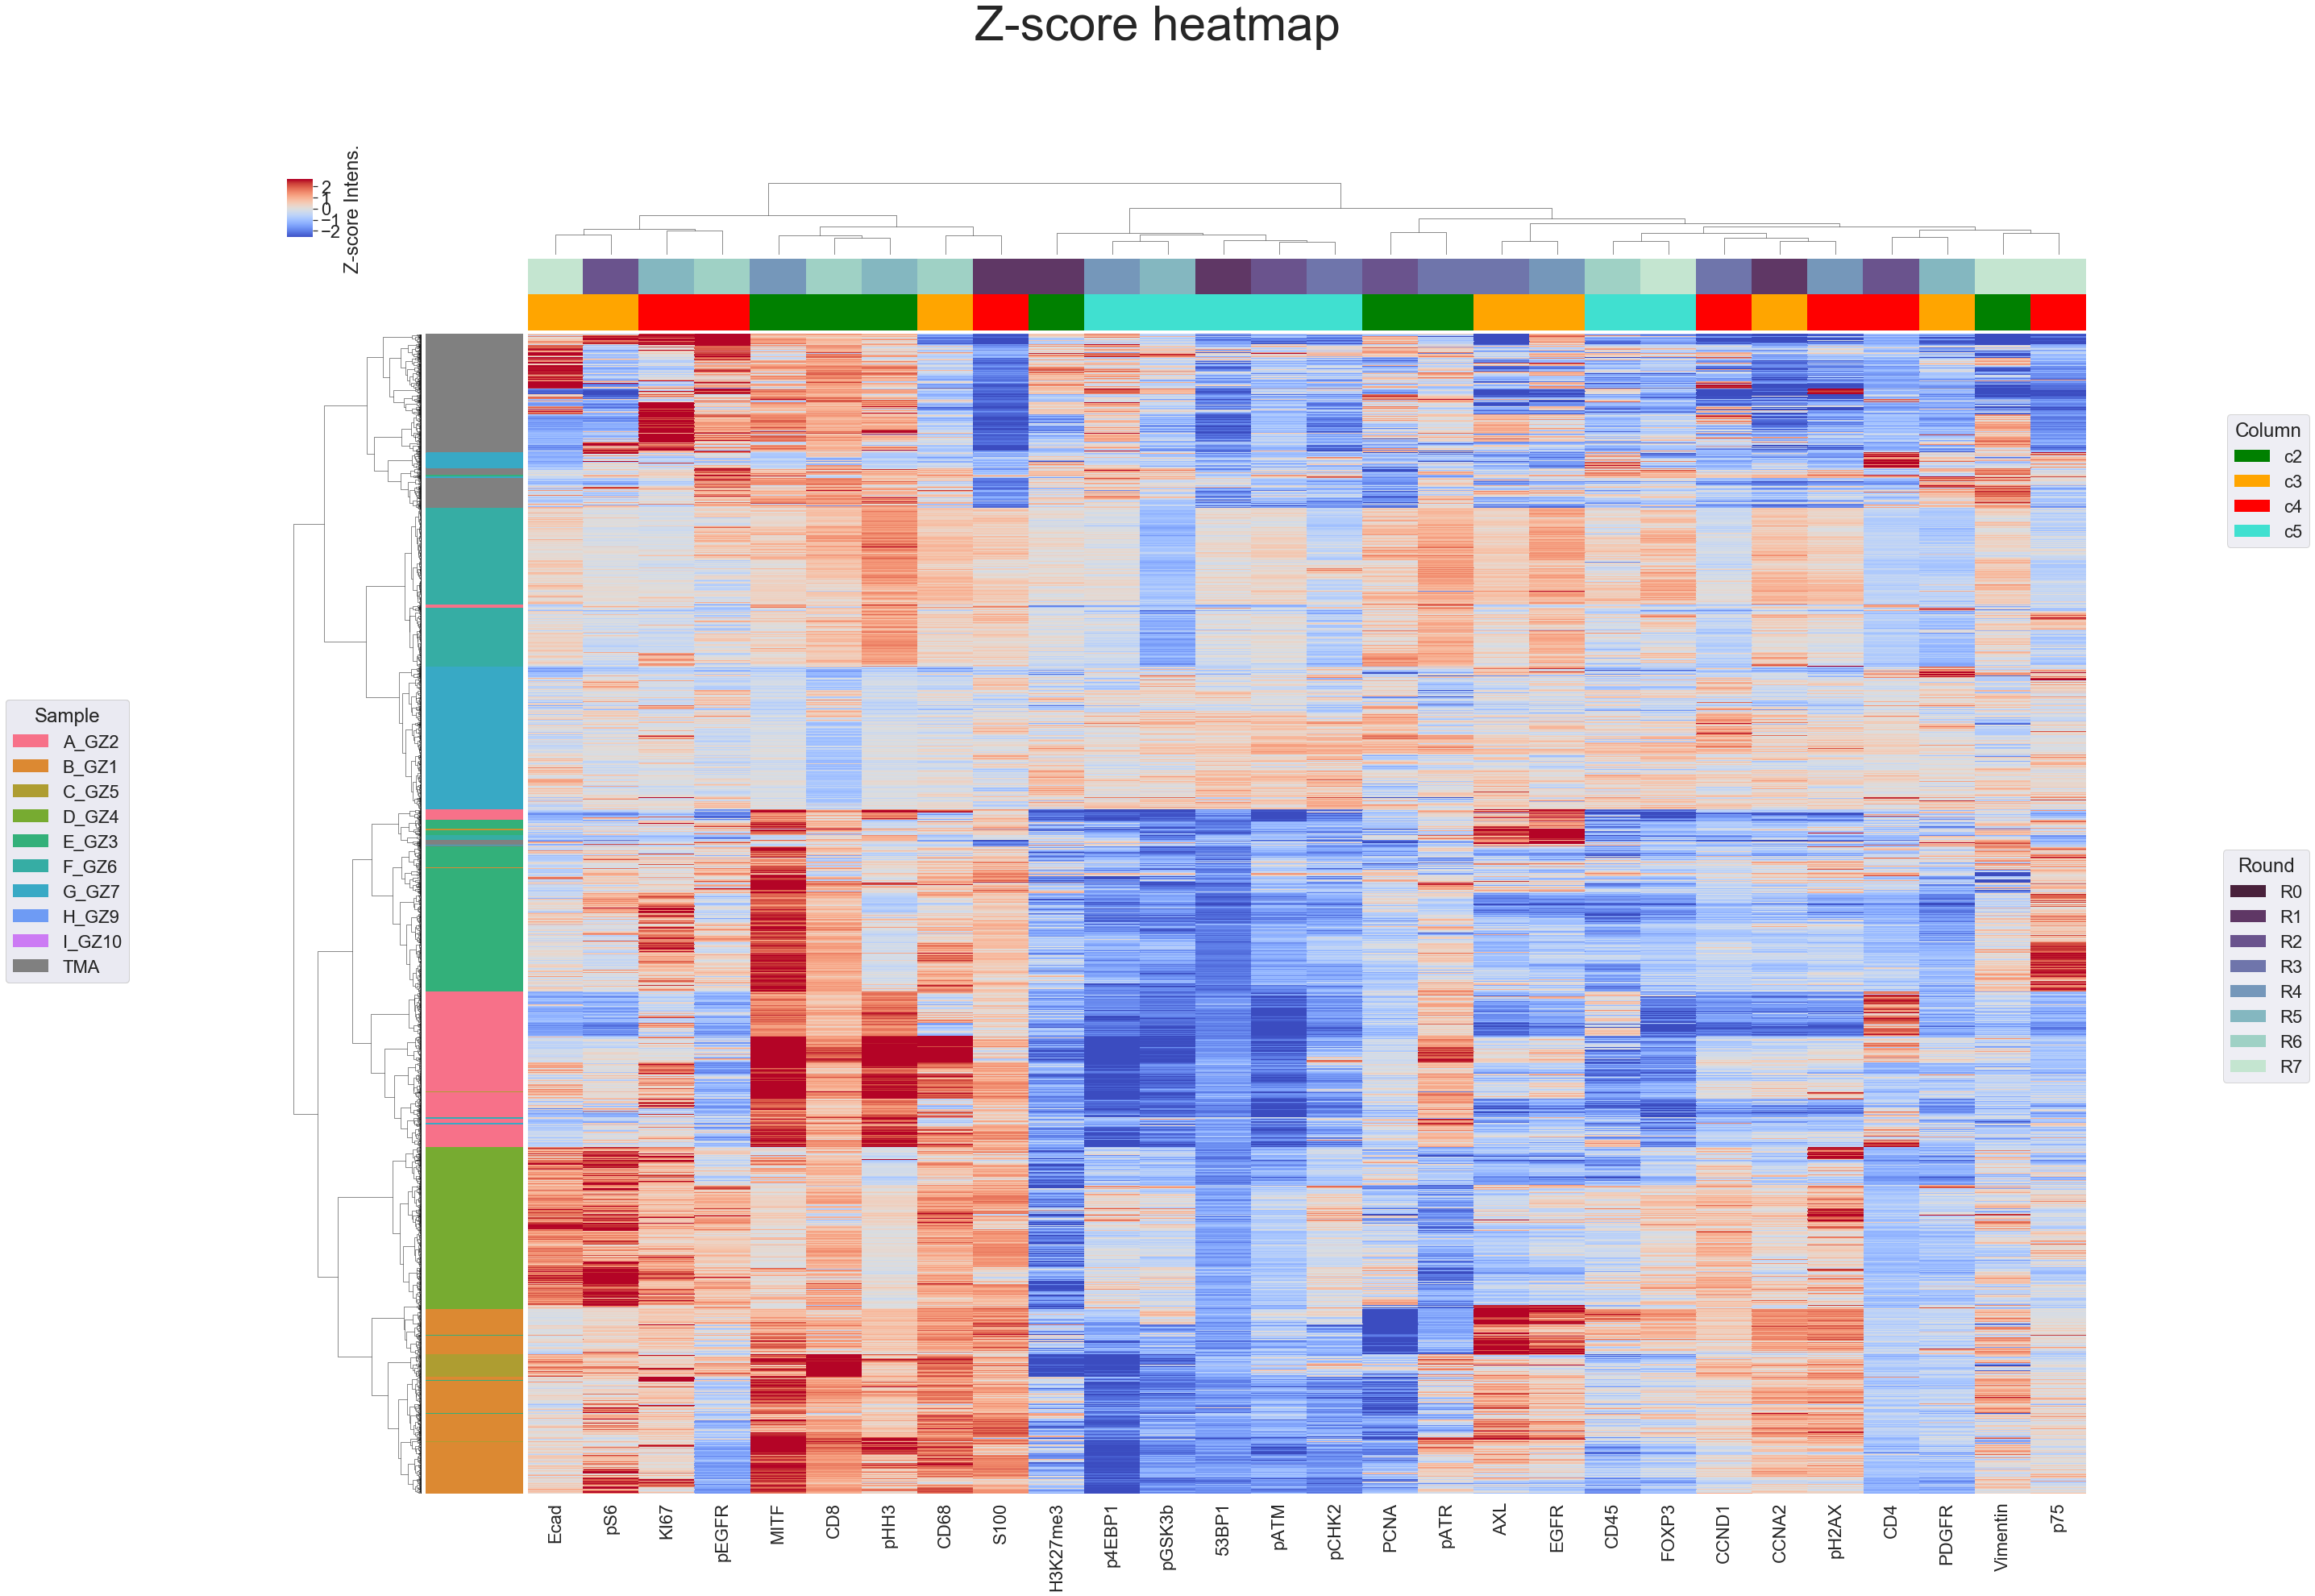

In [44]:
heatmap_function(
    data = subset_df.loc[:,~subset_df.columns.isin(not_intensities)],
    title = "Z-score heatmap",
    # define method, metric, and color map
    method = 'ward', metric = 'euclidean', cmap = 'coolwarm',
    # colorbar (legend coloring of main plot) 
    cbar_kws = {'label':'Z-score Intens.'},
    # xticklabels - want to have the nicknames instead of full names,
    # so we translate from full to short names; we also only want to include
    # non_intensity columns, to match the data we fed into under 'data'
    xticklabels = [full_to_short_names[name] for name in 
                     subset_df.loc[:,
                                 ~subset_df.columns.isin(not_intensities)].columns.values],
    # where to save the dataframe 
    save_loc = output_images_dir,
    # Boolean values for clustering
    row_cluster = True, col_cluster = True,
    # provide annotations established aboved
    annotations = anns
          )

## Bar plot of log2/z-score data

In [45]:
# Create sorted list of sample IDs
samples = sorted(list(df.Sample_ID.copy().unique()))

In [46]:
# Get counts for each Sample_ID, sorted by Sample_ID
counts = pd.DataFrame(df.Sample_ID.value_counts()).sort_index()
counts = counts.rename(columns = {'Sample_ID':'counts'})
counts['Sample_ID'] = counts.index
counts['color'] = counts.apply(lambda row: sample_color_dict[row['Sample_ID']], axis = 1)
counts.head()

,counts,Sample_ID,color
A_GZ2,66137,A_GZ2,"(0.9677975592919913, 0.44127456009157356, 0.53..."
B_GZ1,1443,B_GZ1,"(0.8616090647292522, 0.536495730113334, 0.1954..."
C_GZ5,185,C_GZ5,"(0.6804189127793346, 0.6151497514677574, 0.194..."
D_GZ4,47135,D_GZ4,"(0.46810256823426105, 0.6699492535792404, 0.19..."
E_GZ3,5502,E_GZ3,"(0.20125317221201128, 0.6907920815379025, 0.47..."


#### Bar plot - cell counts by Sample_ID

In [47]:
fig = go.Figure()
title = 'Cell counts by Sample_ID - log2 and z-score'

for sample in ls_samples:
    fig.add_trace(go.Bar(
        x=counts.loc[counts['Sample_ID']==sample,'Sample_ID'], 
        y = counts.loc[counts['Sample_ID']==sample,'counts'],
        text = counts.loc[counts['Sample_ID']==sample,'counts'], textposition='outside',
        marker=dict(
            color='rgb' + str(sample_color_dict[sample])
        ), showlegend = False
    ))
fig.update_layout(title = title, plot_bgcolor = 'white')
fig.update_xaxes(title_text = 'Sample ID', linecolor = 'black')
fig.update_yaxes(title_text = 'Cell count', linecolor = 'black')
#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


### Distributions of log2/z-score data

In [ ]:
# per-sample, per-marker distribution plots

# change column names for visualization
df = df.rename(columns = full_to_short_names)

for sample in ls_samples:
    for marker in [m for m in df.columns.values if m not in not_intensities]:
        make_distr_plot_per_sample(
        title = sample + " " + marker,# + " Z-score",
        dfs = [
            df.loc[df['Sample_ID']==sample,:].copy()],
        df_names = [sample],
        colors = [sample_color_dict[sample]],
        x_label = "Z-score intensity",
        legend = False,
        markers = marker,
        location = output_images_dir)    

# reinstate column names
df = df.rename(columns = short_to_full_names)


### Correlation plot

Get Pearson correlations and P values for all marker values

First, get we need to determine how many columns we will be evaulating. And prepare empty Numpy arrays to hold our data.

In [48]:
n_corr_cols = len(df.columns[~df.columns.isin(not_intensities)])
print(n_corr_cols)

28


In [49]:
pvalues = np.empty((n_corr_cols, n_corr_cols))
corrvalues = np.empty((n_corr_cols,n_corr_cols))

Next, we create a dataframe of only the columns we will use for this analysis.

In [50]:
for_corr = df.loc[:,~df.columns.isin(not_intensities)].copy()
for_corr = for_corr.rename(columns = full_to_short_names)
for_corr.shape

(692976, 28)

Then, we iterate through each pair of columns, calculate the Pearson correlation and associated p-value, and then store the values.

In [51]:
for i in range(for_corr.shape[1]):
    for j in range(0,for_corr.shape[1]):
        col1 = for_corr[for_corr.columns.values[i]]
        col2 = for_corr[for_corr.columns.values[j]]
        corrvalues[i,j] = pearsonr(col1,col2)[0]
        pvalues[i,j] = pearsonr(col1,col2)[1]

To prepare for visualization, we are rounding the values.

In [52]:
corrvalues = pd.DataFrame(corrvalues).round(3)
corrvalues.columns = for_corr.columns.values
corrvalues.index = for_corr.columns.values

pvalues = pd.DataFrame(pvalues)
pvalues.columns = for_corr.columns.values
pvalues.index = for_corr.columns.values

### Option 1

Option 1: no correlation value on plot, just put p value and have star is p<=0.05

In [53]:
# function to append astetisk to row values meeting significance level
def p_add_star(row):
    sig_leve = 0.05
    # This is a lon glist comprehension that uses if/else to determine output
    m = [str('{:0.3e}'.format(m)) + "*" 
         if m <= 0.05 \
         else str('{:0.3e}'.format(m))
        for m in row ]
    return pd.Series(m)

# Create a copy of the original df
p_w_star = pvalues.copy()
# Append asterisk to significant values
p_w_star = p_w_star.apply(lambda row: p_add_star(row), axis = 1)
# Supply column names - they were erased during the previous step
p_w_star.columns = for_corr.columns.values

# FYI - display
p_w_star.head()

,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,4.916e-283*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,4.856e-59*
AXL,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,3.292e-77*,0.000e+00*,0.000e+00*,0.000e+00*,4.774e-221*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CCNA2,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CCND1,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,1.642e-44*,0.000e+00*,4.561e-307*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CD45,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,2.263e-112*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*


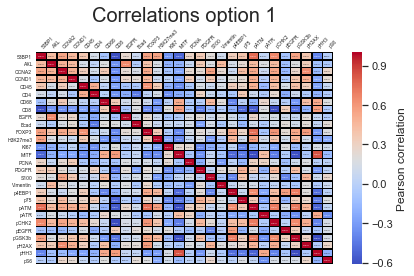

In [54]:
### Correlation visualization

sb.set()

# Label axes
x_axis_labels = for_corr.columns.values.tolist()
y_axis_labels = for_corr.columns.values.tolist()

# Plot data
ax = sb.heatmap(
    # Data for plotting
    corrvalues, 
    # Annotation - the display text on boxes
    annot=p_w_star, 
    # Annotation keywords. "size" adjusts font sixe
    annot_kws={"size": 1.25},
    # Format = string for annotations
    fmt='s',
    # Set labels fo x and y axes
    xticklabels=x_axis_labels, yticklabels=y_axis_labels,
    # Color bay heywords. Here we label it to represent what the color represents
    cbar_kws = {'label':'Pearson correlation'},
    # Add black lines of designated width and color between boxes
    linecolor = 'black', linewidth = 0.5,
    # Colormap to use to color boxes
    cmap = 'coolwarm'
                )

# Make axis tick lengths 0
ax.tick_params(length=0)

# Adjust y-axis labels
plt.yticks(rotation=0, size = 5)

# Adjust x-axis labels
ax.xaxis.tick_top() # supply x-ticks along top of blot
ax.xaxis.set_label_position('top') # move x-axis labels to top of plot, instead of along bottom
plt.xticks(rotation=45, size = 5)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left') # align along left

# Adjust title and general appearance
ax.set_title(label = "Correlations option 1", fontsize = 20)
plt.tight_layout()

# Plot output
filename = "correlations_option1.png"
filename = os.path.join(output_images_dir, filename)
plt.savefig(filename,dpi=500)

### Option 2

Option 2: include correlation and 1-3 stars depending on p-value. 1 star: p-value <= 0.05; 2 stars: p-value <= 0.01; 3 stars: p-value <= 0.001.

In [55]:
# function to replace significance levels in rows with apprpriate number of stars based on threshold levels
def p_to_star(row):
    output  = []
    thrd1 = 0.001
    thrd2 = 0.01
    thrd3 = 0.05
    for item in row:
        # Determine appropirate number of stars
        if item <= thrd1:
            stars = 3
        elif item <= thrd2:
            stars = 2
        elif item <= thrd3:
            stars = 1
        else:
            stars = 0
        value = ''
        # Construct star string of appr. length
        for i in range(stars):
            value += '*'
        output.append(value)
    return pd.Series(output)

# Create copy of original df
p_as_stars = pvalues.copy()
# Replace values with appropriate number of stars
p_as_stars = p_as_stars.apply(lambda row: p_to_star(row), axis = 1)
# Suuply headers - previous step erased them
p_as_stars.columns = for_corr.columns.values
# FYI - display
p_as_stars.head()

,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
AXL,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CCNA2,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CCND1,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CD45,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***


In [56]:
# View final df - join corr and stars
corr_w_star = corrvalues.round(2).astype(str) + p_as_stars
corr_w_star.head()

,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,1.0***,0.44***,0.55***,0.46***,0.38***,0.14***,-0.1***,-0.6***,0.26***,0.08***,...,0.33***,0.4***,0.76***,0.04***,0.66***,-0.1***,0.56***,0.38***,-0.39***,-0.02***
AXL,0.44***,1.0***,0.49***,0.45***,0.14***,0.02***,0.18***,-0.34***,0.66***,-0.04***,...,0.14***,0.25***,0.44***,0.17***,0.45***,-0.12***,0.18***,0.35***,-0.11***,-0.05***
CCNA2,0.55***,0.49***,1.0***,0.5***,0.34***,0.14***,0.37***,-0.35***,0.24***,0.15***,...,0.08***,0.44***,0.52***,0.08***,0.54***,-0.15***,0.27***,0.65***,-0.14***,0.28***
CCND1,0.46***,0.45***,0.5***,1.0***,0.15***,-0.08***,0.16***,-0.32***,0.28***,0.23***,...,0.19***,0.24***,0.51***,-0.02***,0.48***,-0.04***,0.39***,0.5***,-0.25***,0.24***
CD45,0.38***,0.14***,0.34***,0.15***,1.0***,0.51***,0.03***,-0.27***,-0.09***,-0.07***,...,0.34***,0.28***,0.49***,-0.15***,0.44***,0.16***,0.42***,0.33***,-0.27***,0.06***


In [57]:
corrvalues.shape

(28, 28)

In [58]:
corr_w_star.shape

(28, 28)

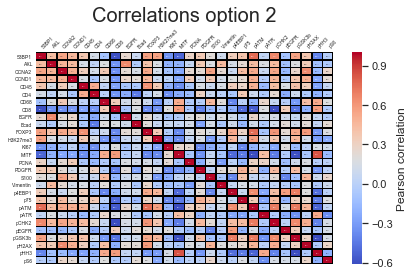

In [59]:
### Correlation visualization

sb.set()

# Axes labels
x_axis_labels = for_corr.columns.values.tolist()
y_axis_labels = for_corr.columns.values.tolist()

# Construct plot
ax = sb.heatmap(
    # data to be plotted
    corrvalues, 
    # Suuply annotations - the text to be displayed in each box
    annot=corr_w_star, 
    # Annotation keywords - adjust font size
    annot_kws={"size": 1.25},
    # Format of annotation is string
    fmt='s',
    # Supply axies labels
    xticklabels=x_axis_labels, yticklabels=y_axis_labels,
    # Colorbar keywords - label for what the color scale represents
    cbar_kws = {'label':'Pearson correlation'},
    # Add lines of designated width and color between boxes
    linecolor = 'black', linewidth = 0.5,
    # Determine colormap to be used for coloring
    cmap = 'coolwarm'
                )

# Make axis tick lengths 0
ax.tick_params(length=0)

# Adjust y-axis aesthetics
plt.yticks(rotation=0, size = 5)

# Adjust x-axis aesthetics
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') # x-axis labels on top
plt.xticks(rotation=45, size = 5)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left') # align left

# Adjust title and general appearance
ax.set_title(label = "Correlations option 2", fontsize = 20)
plt.tight_layout()

# Plot output
filename = "correlations_option2.png"
filename = os.path.join(output_images_dir, filename)
plt.savefig(filename,dpi=500)

### Save correlations and p-value data

In [60]:
filename = "zscore_pearson_correlations.csv"
filename = os.path.join(output_data_dir, filename)
corrvalues.to_csv(filename, index = True)

In [61]:
filename = "zscore_pearson_p-values.csv"
filename = os.path.join(output_data_dir, filename)
pvalues.to_csv(filename, index = True)

### Drop any other rows or columns we want to before saving data

In [ ]:
# Let's take a look
df.columns.values

For the sake of example, I will operate on a copy of df, called df_copy

In [ ]:
# You MUST do df.copy()
# 'df_copy = df' would essentially 
# give you two different names for the
# SAME dataframe, so operating on one
# would also operate on the other
df_copy = df.copy()

#### Operate on entire rows or columns

In [ ]:
# Drop columns
my_cols = []
df_copy = df_copy.drop(columns = my_cols)

In [ ]:
# Keep only specific columns (explained below)
my_cols = []
my_cols = df.columns.values
df_copy = df_copy.loc[:,my_cols]

#### Operate on rows and columns using filtering criteria

In [ ]:
# Keep only certain rows based off of criteria

# use df.loc[] to filter
# df.loc[rows,columns]
# df.loc[:,certain_cols] --> keep all rows ':', only certain cols
# df.loc[certain_rows,:] --> keep only certain row, all cols ':'

# Say we only want certain values for Sample_ID
print(df_copy.Sample_ID.unique())
keep = ['TMA1.1','TMA1.2','TMA1.3','TMA2.1','TMA2.2','TMA2.3']
df_copy = df_copy.loc[df_copy['Sample_ID'].isin(keep),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Filter on multiple criteria
# '&' or 'and'
# '|' or 'or'
# you MUST have parentheses around each logic expression!
df_copy = df_copy.loc[
    (df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        | (df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Remove rows based off of certain criteria
# note the negating tilde '~'!

df_copy = df_copy.loc[
    (~df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        & (~df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

### Save the data by Sample_ID

In [62]:
# Check for existence of output file first
for sample in ls_samples:
    filename = sample + "_" + step_suffix + ".csv
    filename = os.path.join(output_data_dir, filename)
    if os.path.exists(filename):
        print("File by name "+filename+" already exists.")

File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/A_GZ2_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/B_GZ1_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/C_GZ5_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/D_GZ4_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/E_GZ3_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/F_GZ6_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/G_GZ7_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/I_GZ10_zscore.csv already exists.
File by name /Users/groutm/Desktop/gz_new/gz_new_zscore/TMA_zscore.csv already exists.


In [63]:
# Save output files
for sample in ls_samples:
    df_save = df.loc[df['Sample_ID'] == sample,:]
    filename = sample + "_" + step_suffix + ".csv"
    filename = os.path.join(output_data_dir, filename)
    df_save.to_csv(filename, index = True)
